In [1]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split as split
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

In [2]:
songs_df = pd.read_csv('/kaggle/input/song-popularity-dataset/song_data.csv')
songs_df.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams               73            262333   
1                  In The End               66            216933   
2           Seven Nation Army               76            231733   
3                  By The Way               74            216933   
4           How You Remind Me               56            223826   

   acousticness  danceability  energy  instrumentalness  key  liveness  \
0      0.005520         0.496   0.682          0.000029    8    0.0589   
1      0.010300         0.542   0.853          0.000000    3    0.1080   
2      0.008170         0.737   0.463          0.447000    0    0.2550   
3      0.026400         0.451   0.970          0.003550    0    0.1020   
4      0.000954         0.447   0.766          0.000000   10    0.1130   

   loudness  audio_mode  speechiness    tempo  time_signature  audio_valence  
0    -4.095           1       0.0294  167.060               4          0.474  
1    -6.407           0       0.0498  105.256               4          0.370  
2    -7.828           1       0.0792  123.881               4          0.324  
3    -4.938           1       0.1070  122.444               4          0.198  
4    -5.065           1       0.0313  172.011               4          0.574

In [3]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [4]:
#Check for null values
songs_df.isnull().values.any()

False

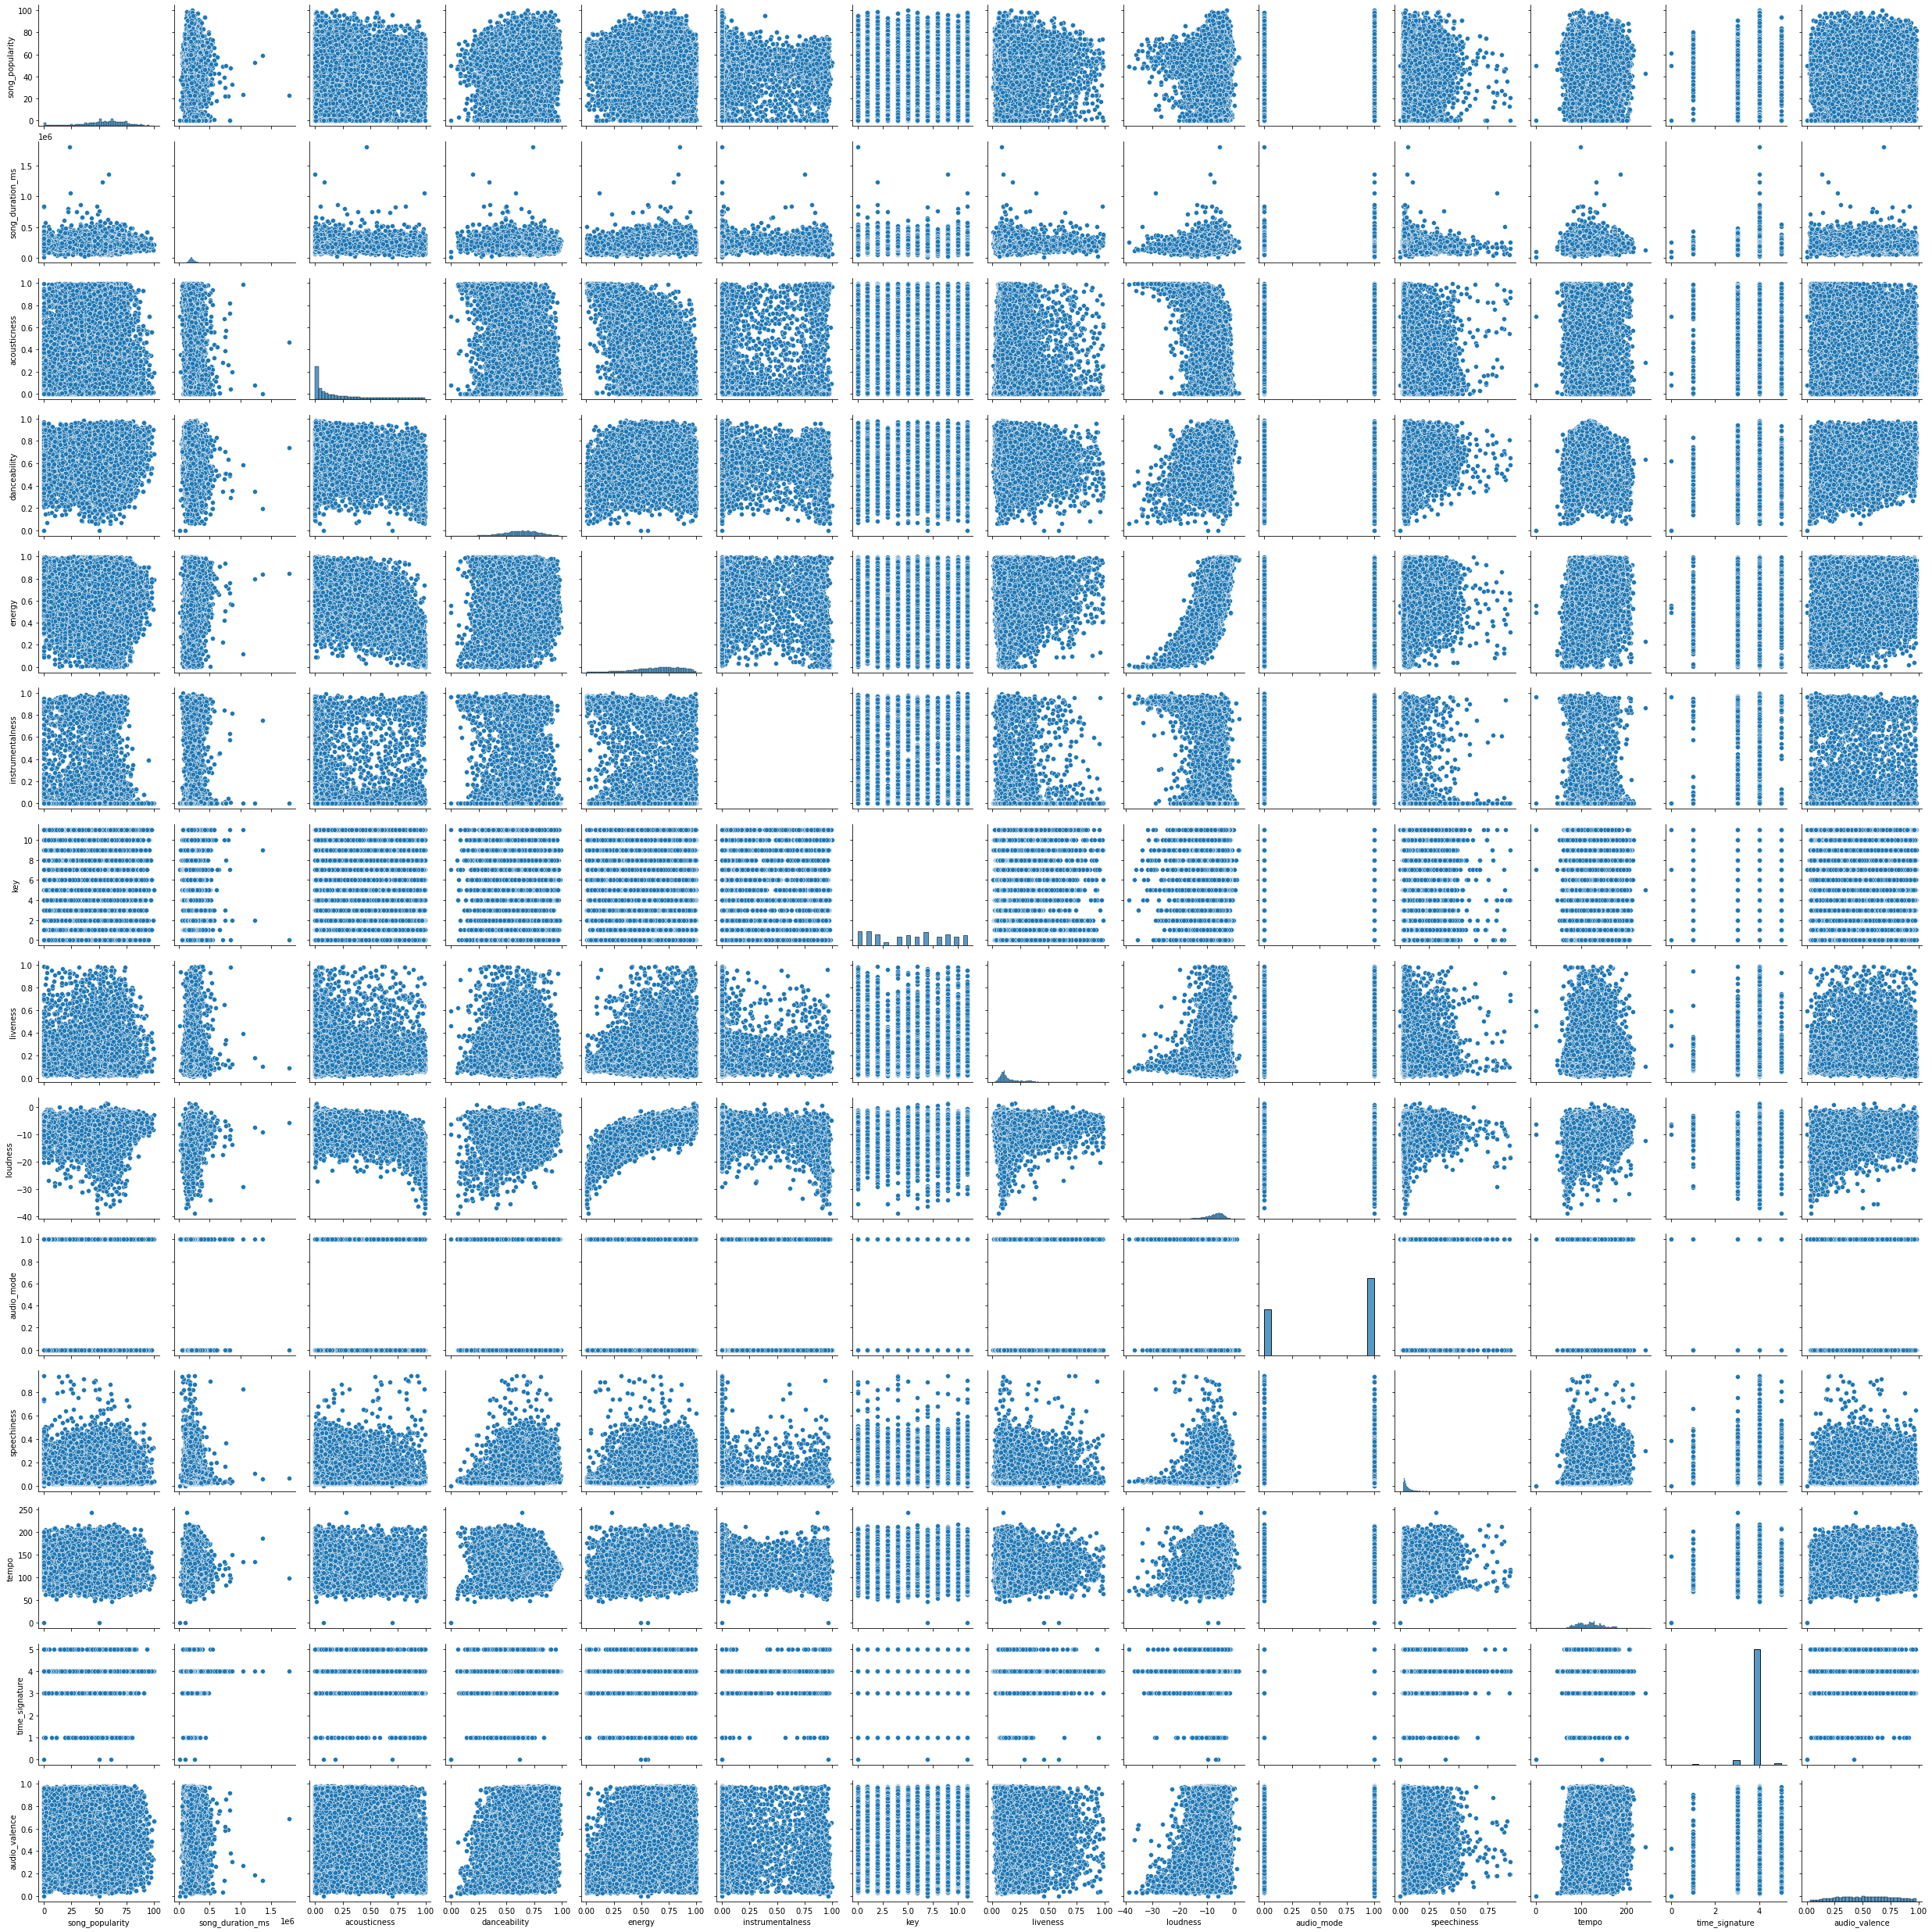

In [5]:
sns.pairplot(songs_df)

(array([ 262.,  451.,  761., 1116., 1927., 2656., 3097., 3366., 3150.,
        2049.]),
 array([0.00107 , 0.100863, 0.200656, 0.300449, 0.400242, 0.500035,
        0.599828, 0.699621, 0.799414, 0.899207, 0.999   ]),
 <BarContainer object of 10 artists>)

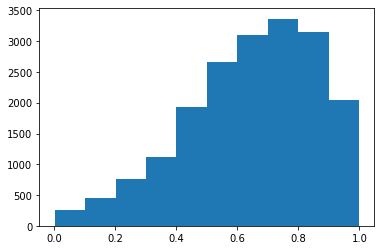

In [6]:
# energy values are between 0 to 1
plt.hist(songs_df.energy)

(array([7407., 6327., 2111., 1682.,  470.,  280.,  267.,  159.,   78.,
          54.]),
 array([0.0109 , 0.10841, 0.20592, 0.30343, 0.40094, 0.49845, 0.59596,
        0.69347, 0.79098, 0.88849, 0.986  ]),
 <BarContainer object of 10 artists>)

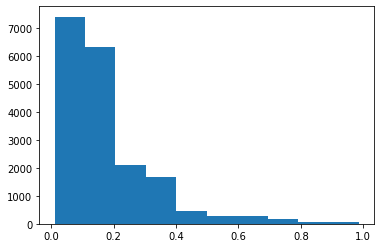

In [7]:
# liveness values are between 0 to 1

plt.hist(songs_df.liveness)

(array([6.000e+00, 1.700e+01, 4.300e+01, 8.600e+01, 1.940e+02, 5.170e+02,
        2.186e+03, 6.575e+03, 8.871e+03, 3.400e+02]),
 array([-38.768 , -34.7327, -30.6974, -26.6621, -22.6268, -18.5915,
        -14.5562, -10.5209,  -6.4856,  -2.4503,   1.585 ]),
 <BarContainer object of 10 artists>)

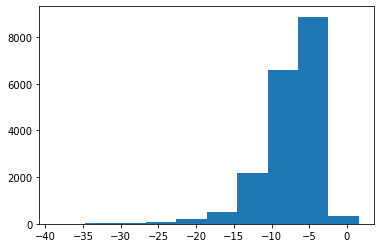

In [8]:
# loudness values are negative and not between 0 to 1

plt.hist(songs_df.loudness)

<AxesSubplot:>

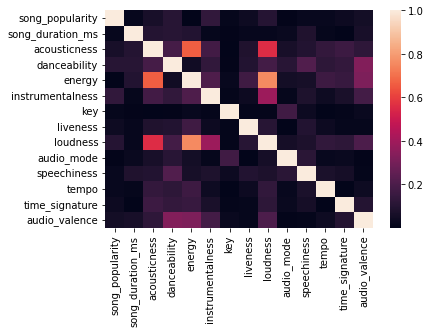

In [9]:
#find correlation in the data
corr = songs_df.corr().abs()
sns.heatmap(corr)

In [10]:
class SongsPopularityTransformer():
    def __init__(self):
        pass
    def transform(self, db):
        db['loudness'] = db['loudness'].abs() #converting values to positive
        db['loudness'] = (db['loudness'] - np.min(db['loudness']))/(np.max(db['loudness']) - np.min(db['loudness']))
        #scaling values range to be between 0 and 1
        db = db[['song_popularity', 'acousticness','energy', 'loudness', 'instrumentalness', 'liveness']]
        return db

In [11]:
#split the data
songs_train, songs_test = split(songs_df, train_size=0.7, random_state=433)
songs_valid, songs_test = split(songs_test, train_size=0.5, random_state=433)

In [12]:
#transforming the data
songs_transformer = SongsPopularityTransformer()
songs_train_trans = songs_transformer.transform(songs_train)
songs_valid_trans = songs_transformer.transform(songs_valid)
songs_test_trans = songs_transformer.transform(songs_valid)

In [13]:
#Linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
songs_lm = LinearRegression()
X_train = songs_train_trans.drop('song_popularity', axis=1)
y_train = songs_train_trans['song_popularity']

In [14]:
songs_lm.fit(X_train, y_train)

LinearRegression()

In [15]:
print("The model intercept is: {}".format(songs_lm.intercept_))
print("The model Coefficients are: {}".format(songs_lm.coef_[0]))
formula = 'Song popularity = ' + f'{songs_lm.intercept_:.3f}'
for coef, feature in zip(songs_lm.coef_, songs_train_trans.columns[:-1]):
    formula += f'{coef:+.3f}*{feature}'
print(formula)

The model intercept is: 76.30239866306616
The model Coefficients are: -7.72046492679186
Song popularity = 76.302-7.720*song_popularity-19.882*acousticness-35.320*energy-8.940*loudness-3.977*instrumentalness


In [16]:
songs_train_trans = songs_train_trans.merge(pd.Series(songs_lm.predict(X_train)).rename('popularity_pred'),
             left_index=True, right_index=True)
songs_train_trans.head()

song_popularity  acousticness  energy  loudness  instrumentalness  \
7494                69        0.0267   0.628  0.126537          0.000004   
8956                 3        0.0089   0.944  0.107206          0.000000   
10021               70        0.4750   0.607  0.117103          0.000000   
3582                60        0.0114   0.713  0.149085          0.018300   
10242               39        0.6580   0.638  0.227145          0.839000   

       liveness  popularity_pred  
7494     0.1190        53.864931  
8956     0.1730        54.395316  
10021    0.0812        54.574321  
3582     0.0608        59.680218  
10242    0.1410        58.332070

In [17]:
rmse_train = np.sqrt(mean_squared_error(songs_train_trans['popularity_pred'], songs_train_trans['song_popularity']))
print(f"RMSE = {rmse_train:.2f}")

RMSE = 21.87


In [18]:
X_valid = X_train = songs_valid_trans.drop('song_popularity', axis=1)
songs_valid_trans_pred = songs_lm.predict(X_valid)
                                          
songs_valid_trans = songs_valid_trans.merge(pd.Series(songs_valid_trans_pred).rename('popularity_pred'),left_index=True, right_index=True)
songs_valid_trans.head()

song_popularity  acousticness  energy  loudness  instrumentalness  \
301                66        0.4650   0.483  0.119683          0.497000   
2167               74        0.6000   0.472  0.226621          0.000004   
470                72        0.4990   0.350  0.386648          0.000008   
1017                5        0.0328   0.771  0.152909          0.000001   
1034               52        0.0187   0.666  0.149955          0.692000   

      liveness  popularity_pred  
301     0.0686        56.054324  
2167    0.3170        52.719474  
470     0.0844        51.838627  
1017    0.0594        49.292888  
1034    0.1120        53.574185

In [19]:
rmse_valid = np.sqrt(mean_squared_error(songs_valid_trans['popularity_pred'], songs_valid_trans['song_popularity']))
print(f"RMSE = {rmse_valid:.2f}")

RMSE = 21.00


In [20]:
X_test = X_train = songs_test_trans.drop('song_popularity', axis=1)
songs_test_trans_pred = songs_lm.predict(X_test)
                                          
songs_test_trans = songs_test_trans.merge(pd.Series(songs_test_trans_pred).rename('popularity_pred'),left_index=True, right_index=True)
songs_test_trans.head()

song_popularity  acousticness  energy  loudness  instrumentalness  \
301                66        0.4650   0.483  0.119683          0.497000   
2167               74        0.6000   0.472  0.226621          0.000004   
470                72        0.4990   0.350  0.386648          0.000008   
1017                5        0.0328   0.771  0.152909          0.000001   
1034               52        0.0187   0.666  0.149955          0.692000   

      liveness  popularity_pred  
301     0.0686        56.054324  
2167    0.3170        52.719474  
470     0.0844        51.838627  
1017    0.0594        49.292888  
1034    0.1120        53.574185

In [21]:
rmse_test = np.sqrt(mean_squared_error(songs_test_trans['popularity_pred'], songs_test_trans['song_popularity']))
print(f"RMSE = {rmse_test:.2f}")


RMSE = 21.00


In [22]:
print(f'rmse scores: Train - {rmse_train:.2f}, Valid - {rmse_valid:.2f} and Test - {rmse_test:.2f}')

rmse scores: Train - 21.87, Valid - 21.00 and Test - 21.00


In [23]:
# Secision tree regression
#X = songs_train.drop('song_popularity', axis=1)
#y = songs_train['song_popularity']

#model = DecisionTreeRegressor(max_leaf_nodes=10)
#model.fit(X, y)